Download shakespeare text [here](https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt) and place in root-level data folder

In [3]:
import jax
import flax.nnx as nnx
from jax import random
from genlearn.data_utils.shakespeare import get_shakespeare_dataset, decode, encode
import grain.python as grain
import jax.numpy as jnp

In [4]:
X = get_shakespeare_dataset()
print(X.shape)

(32777, 128)


### DataLoader Setup

In [6]:
# Grain doesn't natively support an in-memory jax array like we have here - quick utility class
from typing import SupportsIndex
class ArraySource(grain.RandomAccessDataSource):
    def __init__(self, array: jax.Array):
        self._array = array

    def __len__(self) -> int:
        return self._array.shape[0]

    def __getitem__(self, i: SupportsIndex) -> jax.Array:
        return self._array[i]

In [ ]:
n_epochs = 10
data_seed = 0
batch_size = 32
n_vocab = 95+1 # X.max() - X.min()

sampler = grain.IndexSampler(
    num_records=X.shape[0], num_epochs=n_epochs, shuffle=True, seed=data_seed
)
data_loader = grain.DataLoader(
    sampler=sampler,
    operations=[grain.Batch(batch_size=batch_size)],
    data_source=ArraySource(X),
)

In [ ]:
# TODO: add causal masking
# TODO: add skip connections at the right places this time :) 
# TODO: what is layernorm btw

In [ ]:
# now define the model itself. First, the embedding
class Embed(nnx.Module): 

    def __init__(self, n_vocab: int, embed_dim: int=2, *, rngs: nnx.Rngs):
        self.embed_lookup = nnx.Param(rngs.uniform(shape=(n_vocab, embed_dim)))
        self.n_vocab = n_vocab
    
    @nnx.jit
    def __call__(self, x: jax.Array) -> jax.Array:
        # embed
        z = nnx.one_hot(x, self.n_vocab) @ self.embed_lookup
        return z


x_bt = nnx.Rngs(0).choice(jnp.arange(95), (32, 128))
emb = Embed(n_vocab=95, embed_dim=2, rngs=nnx.Rngs(0))
x_bte =emb(x_bt) 
assert x_bte.shape == (32, 128, 2)

In [ ]:
L = 30
D = x_bte.shape[2] # embedding dim

@jax.jit
@jax.vmap  # over batch dimension
@jax.vmap  # over sequence position
@jax.vmap  # over embedding dimension
def _add_posenc(x: jax.Array, n: jax.Array, i: jax.Array) -> jax.Array:
    'Scalar implementation of positional encoding'
    return jax.lax.cond(
        i % 2 == 0,  # if i is even
        lambda x: x + jnp.sin(n / (L ** (i / D))),
        lambda x: x + jnp.cos(n / (L ** ((i - 1) / D))),
        x,
    )


# creates repeating grids of 0, 1... repeated across every dimension 
# except 1 (token dim) for n, and 2 (embedding dim) for i
n_grid = jax.lax.broadcasted_iota(jnp.float32, shape=x_bte.shape, dimension=1)
i_grid = jax.lax.broadcasted_iota(jnp.float32, shape=x_bte.shape, dimension=2)

posenc = _add_posenc(x_bte, n_grid, i_grid) - x_bte

In [217]:
from einops import einsum, rearrange
from jax import Array

# Now a single attention layer
class AttentionLayer(nnx.Module):
    "Implements scaled dot product attention with a nifty einsum calc"

    def __init__(
        self,
        n_heads: int,
        d_head: int,
        d_embed: int,
        dtype: jax.typing.DTypeLike = jnp.float32,
        seqlen: int = 128, 
        *, 
        rngs: nnx.Rngs,
    ):
        self.n_heads = n_heads
        self.d_head = d_head
        self.d_embed = d_embed

        def init_attn_weight(*shape: int):
            return nnx.Param(nnx.initializers.kaiming_normal()(rngs(), shape=shape, dtype=dtype))

        # fmt: off
        self.WQ_hed = init_attn_weight(n_heads, d_embed, d_head)
        self.WK_hed = init_attn_weight(n_heads, d_embed, d_head)
        self.WV_hed = init_attn_weight(n_heads, d_embed, d_head)
        self.WO_ge  = init_attn_weight(n_heads * d_head, d_embed) # final output layer after stacking the attention head outputs

        self.layernorm = nnx.LayerNorm(d_embed, rngs=rngs)
        self.out = nnx.Linear(d_embed, d_embed, rngs=rngs)

        mask_bool = jnp.triu(jnp.ones((seqlen, seqlen), dtype=bool), k=1)
        self.mask = jnp.where(mask_bool, -jnp.inf, 0.0)
        # fmt: on

    def attn(self, X_bte: Array) -> Array:
        'Scaled dot-product multi-head self attention'
        # Compute Q, K, V (no KV caching or anything here)
        Q_bthd = einsum(X_bte, self.WQ_hed, 'b t e, h e d -> b t h d')
        K_bthd = einsum(X_bte, self.WK_hed, 'b t e, h e d -> b t h d')
        V_bthd = einsum(X_bte, self.WV_hed, 'b t e, h e d -> b t h d')

        # Compute attention scores
        A_bhtt = einsum(Q_bthd, K_bthd, 'b tq h d, b tk h d -> b h tq tk')
        # add causual attention mask (upper triangular)
        A_bhtt += self.mask
        A_bhtt = nnx.softmax(A_bhtt / jnp.sqrt(self.d_head), axis=-1)
        # self.sow(nnx.Intermediate, 'attn_scores', A_bhtt) # sow to check the masking works properly

        # Multiply by the value matrix, flatten and times by the output matrix
        H_bthd = einsum(A_bhtt, V_bthd, 'b h tq tk, b tk h d -> b tq h d')
        H_btg = rearrange(H_bthd, 'b t h d -> b t (h d)')
        Y_bte = einsum(H_btg, self.WO_ge, 'b t g, g e -> b t e')
        return Y_bte

    def __call__(self, X_bte: Array) -> Array:
        Y_bte = self.attn(X_bte)
        # add skip connection
        Y_bte = Y_bte + X_bte
        Z_bte = self.layernorm(Y_bte)
        Z_bte = self.layernorm(nnx.relu(self.out(Z_bte)) + Z_bte)
        return Z_bte


attn = AttentionLayer(n_heads=4, d_head=2, d_embed=2, rngs=nnx.Rngs(0))
assert attn(x_bte).shape == x_bte.shape  # so we can stack and add residual connections
nnx.display(attn)

In [ ]:
class Transformer(nnx.Module):
    def __init__(
        self,
        n_vocab: int,
        n_heads: int,
        d_head: int,
        d_embed: int,
        num_layers: int = 12,
        dtype: jax.typing.DTypeLike = jnp.float32,
        seqlen: int = 128,
        L_posenc: int = 30,
        *,
        rngs: nnx.Rngs,
    ):        
        self.d_embed = d_embed
        self.L_posenc = L_posenc

        self.embed = Embed(n_vocab=n_vocab, embed_dim=d_embed, rngs=rngs)
        
        self.attn_layers = nnx.List()
        for _ in range(num_layers):
            self.attn_layers.append(
                AttentionLayer(
                    n_heads=n_heads,
                    d_head=d_head,
                    d_embed=d_embed,
                    rngs=rngs,
                    dtype=dtype,
                    seqlen=seqlen
                )
            )

        self.out = nnx.Linear(d_embed, n_vocab, rngs=rngs)


    def add_posenc(self, X_bte):
        D = self.d_embed
        @jax.jit
        @jax.vmap  # over batch dimension      (axis 0)
        @jax.vmap  # over sequence position    (axis 1)
        @jax.vmap  # over embedding dimension  (axis 2)
        def _add_posenc(x: jax.Array, n: jax.Array, i: jax.Array) -> jax.Array:
            'Scalar implementation of positional encoding'
            return jax.lax.cond(
                i % 2 == 0,  # if i is even
                lambda x: x + jnp.sin(n / (self.L_posenc ** (i / D))),
                lambda x: x + jnp.cos(n / (self.L_posenc ** ((i - 1) / D))),
                x,
            )


        # creates repeating grids of 0, 1... repeated across every dimension 
        # except 1 (token dim) for n, and 2 (embedding dim) for i
        n_grid = jax.lax.broadcasted_iota(jnp.float32, shape=X_bte.shape, dimension=1)
        i_grid = jax.lax.broadcasted_iota(jnp.float32, shape=X_bte.shape, dimension=2)
        return _add_posenc(X_bte, n_grid, i_grid)

    def __call__(self, X_btv: Array) -> Array:
        X_bte = self.embed(X_btv)
        X_bte = self.add_posenc(X_bte)
        for layer in self.attn_layers:
            X_bte = layer(X_bte)

        # convert back to logits
        Y_btv = self.out(X_bte)
        return Y_btv

## Test: Can we overfit to one batch?

In [372]:
transformer = Transformer(n_vocab=96, n_heads=8, d_head=128//8, d_embed=128, num_layers=16, rngs=nnx.Rngs(0))

In [373]:
for x in data_loader:
    break

In [ ]:
import optax 
import chex

@nnx.jit
def train_step(model: Transformer, x: Array, optim: nnx.Optimizer):
    # y is off-by-one - so need to truncate to compute the loss
    y_true = nnx.one_hot(x, num_classes=96)
    y_true = y_true[:, 1:, :] # skip first token - eg. start

    def loss_fn(model):
        y = model(x)
        y_pred = y[:, :-1, :] # truncate last entry so they're the same length
        chex.assert_equal_shape((y_true, y_pred))
        cross_entropy_loss = optax.losses.softmax_cross_entropy(y_pred, y_true)

        # need to mask the loss so the model doesn't get reward for predicting pad tokens
        loss_mask = (x>0).astype(jnp.float32)[:, 1:]
        loss = cross_entropy_loss * loss_mask 
        return loss.mean()
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optim.update(model, grads)
    return loss, grads

# tx = optax.adam(learning_rate=optax.schedules.piecewise_constant_schedule(1e-4, {400: 0.2}))

optim = nnx.Optimizer(model=transformer, tx=optax.adam(1e-4), wrt=nnx.Param)

losses = []
for step in range(500):
    loss, grads = train_step(transformer, x, optim) # just fit to a single batch please
    print(loss.mean())
    losses.append(loss.mean())

0.15664957
0.98131484
0.7217472
0.7018733
0.6623721
0.5435897
0.551085
0.49383324
0.42422676
0.41865316
0.3955877
0.34336197
0.30996406
0.30067036
0.29428682
0.27766988
0.25186676
0.22470024
0.2321456
0.23933601
0.2244899
0.21254815
0.21092013
0.20920846
0.20327647
0.19565901
0.18849772
0.18450227
0.1869277
0.188127
0.1810057
0.17553368
0.1752702
0.17441204
0.17248294
0.17223579
0.1714262
0.16827303
0.16591293
0.16605894
0.16522394
0.1630229
0.16211571
0.16199717
0.1610912
0.16000943
0.1593445
0.15882796
0.1580568
0.15759906
0.1572194
0.15649134
0.15558718
0.15521985
0.15516225
0.15466706
0.15403281
0.15372927
0.15336572
0.15292849
0.15271
0.15247488
0.1520443
0.15168105
0.15143117
0.15116644
0.15095633
0.15074886
0.15040012
0.1500715
0.14986145
0.1496636
0.14944954
0.14925031
0.14903566
0.1488048
0.14860642
0.14841671
0.14820364
0.1479874
0.14781646
0.14764468
0.14745703
0.14727068
0.14708616
0.1469182
0.14675988
0.14658092
0.14640668
0.14624718
0.14608172
0.14591518
0.1457577
0.14559

KeyboardInterrupt: 

(0.0, 0.862187922745943)

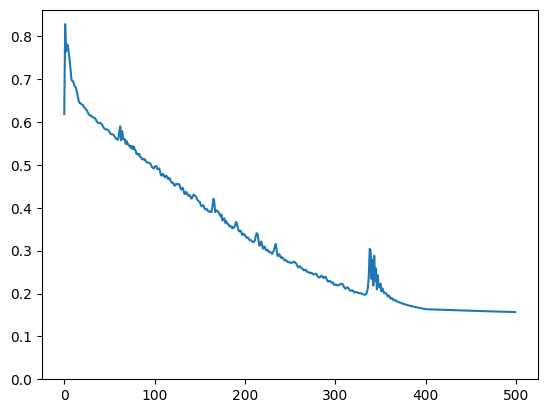

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(losses, scaley='linear')
plt.ylim(0, None)

In [332]:
y = transformer(x[0:1])